In [2]:
###################################################################################################
##
## This code was copied from:
## https://github.com/juglab/DenoiSeg/blob/master/denoiseg/utils/compute_precision_threshold.py
##
    
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy import ndimage

@jit
def pixel_sharing_bipartite(lab1, lab2):
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 1, lab2.max() + 1), dtype=np.int)
    for i in range(lab1.size):
        psg[lab1.flat[i], lab2.flat[i]] += 1
    return psg


def intersection_over_union(psg):
    """
    Computes IOU.
    :Authors:
        Coleman Broaddus
     """
    rsum = np.sum(psg, 0, keepdims=True)
    csum = np.sum(psg, 1, keepdims=True)
    return psg / (rsum + csum - psg)


def matching_iou(psg, fraction=0.5):
    """
    Computes IOU.
    :Authors:
        Coleman Broaddus
     """
    iou = intersection_over_union(psg)
    matching = iou > 0.5
    matching[:, 0] = False
    matching[0, :] = False
    return matching

def measure_precision(iou=0.5, partial_dataset=False):
    def precision(lab_gt, lab, iou=iou, partial_dataset=partial_dataset):
        """
        precision = TP / (TP + FP + FN) i.e. "intersection over union" for a graph matching
        :Authors:
            Coleman Broaddus
        """
        psg = pixel_sharing_bipartite(lab_gt, lab)
        matching = matching_iou(psg, fraction=iou)
        assert matching.sum(0).max() < 2
        assert matching.sum(1).max() < 2
        n_gt = len(set(np.unique(lab_gt)) - {0})
        n_hyp = len(set(np.unique(lab)) - {0})
        n_matched = matching.sum()
        if partial_dataset:
            return n_matched, (n_gt + n_hyp - n_matched)
        else:
            return n_matched / (n_gt + n_hyp - n_matched)

    return precision


def matching_overlap(psg, fractions=(0.5,0.5)):
    """
    create a matching given pixel_sharing_bipartite of two label images based on mutually overlapping regions of sufficient size.
    NOTE: a true matching is only gauranteed for fractions > 0.5. Otherwise some cells might have deg=2 or more.
    NOTE: doesnt break when the fraction of pixels matching is a ratio only slightly great than 0.5? (but rounds to 0.5 with float64?)
    """
    afrac, bfrac = fractions
    tmp = np.sum(psg, axis=1, keepdims=True)
    m0 = np.where(tmp==0,0,psg / tmp)
    tmp = np.sum(psg, axis=0, keepdims=True)
    m1 = np.where(tmp==0,0,psg / tmp)
    m0 = m0 > afrac
    m1 = m1 > bfrac
    matching = m0 * m1
    matching = matching.astype('bool')
    return matching


def measure_seg(partial_dataset=False):
    def seg(lab_gt, lab, partial_dataset=partial_dataset):
        """
        calculate seg from pixel_sharing_bipartite
        seg is the average conditional-iou across ground truth cells
        conditional-iou gives zero if not in matching
        ----
        calculate conditional intersection over union (CIoU) from matching & pixel_sharing_bipartite
        for a fraction > 0.5 matching. Any CIoU between matching pairs will be > 1/3. But there may be some
        IoU as low as 1/2 that don't match, and thus have CIoU = 0.
        """
        psg = pixel_sharing_bipartite(lab_gt, lab)
        iou = intersection_over_union(psg)
        matching = matching_overlap(psg, fractions=(0.5, 0))
        matching[0, :] = False
        matching[:, 0] = False
        n_gt = len(set(np.unique(lab_gt)) - {0})
        n_matched = iou[matching].sum()
        if partial_dataset:
            return n_matched, n_gt
        else:
            return n_matched / n_gt

    return seg

def compute_labels(prediction, threshold):
    prediction_exp = np.exp(prediction[..., 1:])
    prediction_softmax = prediction_exp / np.sum(prediction_exp, axis=2)[..., np.newaxis]
    prediction_fg = prediction_softmax[..., 1]
    pred_thresholded = prediction_fg > threshold
    labels, _ = ndimage.label(pred_thresholded)
    return labels

def write_csv(name, m):
    sourceFile = open(name, 'w')
    strm = str(m)
    print(strm[1:-1], file = sourceFile)
    sourceFile.close()
    
def show(ims):
    plt.figure(figsize=(5*len(ims),5))
    
    for i in range(len(ims)):
        plt.subplot(1,len(ims),i+1)
        plt.imshow(ims[i])

In [3]:
gt = np.load('data/gt.npy').astype(int)
pred = np.load('data/pred.npy').astype(int)

In [4]:
seg = measure_seg()

b = gt.shape[0]
m = []
for i in range(b):
    m.append(seg(gt[i,:,:], pred[i,:,:]))
    
print(m)

<ipython-input-2-633eee638333>:12: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pixel_sharing_bipartite" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(UniTuple(int64 x 2), dtype=Function(<class 'int'>))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'zeros': File: numba/core/typing/npydecl.py: Line 504.
    With argument(s): '(UniTuple(int64 x 2), dtype=Function(<class 'int'>))':
   No match.

During: resolving callee type: Function(<built-in function zeros>)
During: typing of call at <ipython-input-2-633eee638333> (15)


File "<ipython-input-2-633eee638333>", line 15:
def pixel_sharing_bipartite(lab1, lab2):
    <source elided>
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 1, lab2.max() + 1), dtype=np.int)
    ^

  @jit
<ipython-input-2-633eee638333>:12: NumbaWarning: 
Co

[0.0, 0.2976190476190476, 0.21680517615393885, nan, 0.0, 0.27734794615514274, 0.07032457496136012, 0.18983994490586703, nan, 0.16844151453684925, 0.15113733568950075, 0.26598785580539624, 0.3105590062111801, 0.0, 0.1785289469512316, 0.0, 0.09494232475598936, 0.059434165232358005, 0.23972602739726026, 0.11932773109243697, 0.0, 0.0, 0.1374464529581822, 0.2495095902353967, 0.03728070175438596, 0.0, 0.26619075764723527, 0.12, nan, 0.0, 0.0, 0.20903139502509235, 0.08148932612451924, 0.24336283185840707, 0.2647849462365592, 0.3237704918032787, 0.43989603638726443, 0.0, 0.37271214642262895, 0.03571428571428571, 0.12303174332747348, 0.0, nan, 0.20179961486142767, 0.3715728715728716, 0.0, 0.0, 0.17773255109634323, 0.09027777777777778, 0.19069940518741166, 0.09295774647887324, 0.1, 0.1568627450980392, nan, 0.18247148541002073, 0.30214913204955385, 0.07046242004264393, 0.1573530179615706, nan, 0.06667057627648762, 0.12982676396986395, nan, 0.12454821103699212, nan, 0.2844302032628216, 0.176099421

In [5]:
write_csv('data/seg.txt', m)

0.15113733568950075


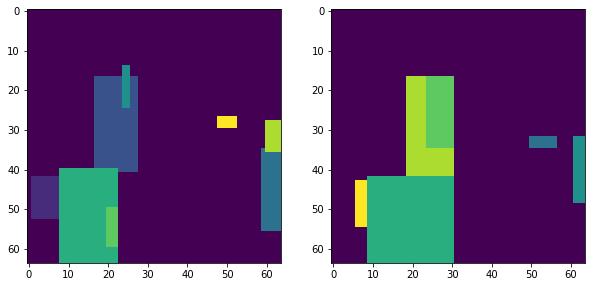

In [8]:
ind = 10
print(m[ind])
show([gt[ind,:,:], pred[ind,:,:]])

In [12]:
seg_av = measure_seg(True)

b = gt.shape[0]

sumIoU = 0.
nGT = 0.
for i in range(b):
    s, n = seg_av(gt[i,:,:], pred[i,:,:])
    sumIoU += s
    nGT += n

m = sumIoU / float(nGT)

print(m)

<ipython-input-2-633eee638333>:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  psg = pixel_sharing_bipartite(lab_gt, lab)
<ipython-input-2-633eee638333>:76: RuntimeWarning: invalid value encountered in true_divide
  m1 = np.where(tmp==0,0,psg / tmp)
<ipython-input-2-633eee638333>:29: RuntimeWarning: invalid value encountered in true_divide
  return psg / (rsum + csum - psg)
<ipython-input-2-633eee638333>:74: RuntimeWarning: invalid value encountered in true_divide
  m0 = np.where(tmp==0,0,psg / tmp)


0.16382311434780691


In [13]:
write_csv('data/seg_av.txt', m)